# 1 Preliminaries
## 1.1 Import

In [1]:
import os
import pandas as pd
import numpy as np
from keras import layers, models, optimizers, utils
import json
import chess
import chess.pgn

## 1.2 Load Data

In [2]:
def read_data(file):
    """
    Reads file and extracts games
    :param file: pgn file
    :return: list of games
    """
    res = []
    games_limit = 2000
    count = 0
    while True:
        try:
            game = chess.pgn.read_game(file)
            if game is None or count >= games_limit:
                break
            res.append(game)
            count += 1
        except Exception as e:
            print(e)
    return res

directory = '../data/lichess/' # data downloaded from https://database.nikonoel.fr/
files = [file for file in os.listdir(directory) if file.endswith('.pgn')]

file_limit = 20 # max files processed
i = 0 # counter to track files processed

games = []
for file in files: # loop through each file in data directory
    if i >= file_limit: break

    with open(directory+file, 'r') as pgn:
        print(file)
        games += read_data(pgn)
        i += 1

len(games)

lichess_elite_2014-07.pgn
lichess_elite_2018-07.pgn
lichess_elite_2016-02.pgn
lichess_elite_2020-03.pgn
lichess_elite_2020-02.pgn
lichess_elite_2016-03.pgn
lichess_elite_2018-06.pgn
lichess_elite_2018-12.pgn
lichess_elite_2014-12.pgn
lichess_elite_2014-06.pgn
lichess_elite_2014-10.pgn
lichess_elite_2014-04.pgn
lichess_elite_2018-04.pgn
lichess_elite_2018-10.pgn
lichess_elite_2016-01.pgn
lichess_elite_2020-01.pgn
lichess_elite_2018-11.pgn
lichess_elite_2018-05.pgn
lichess_elite_2014-05.pgn
lichess_elite_2014-11.pgn


27728

## 1.3 Process Data

In [3]:
def space_to_int(space):
    """
    Taken from here: https://www.youtube.com/watch?v=ffzvhe97J4Q&ab_channel=DigitalSecrets
    :param space: the chess space
    :return: row and column index
    """
    row_val = {'a': 0,'b': 1,'c': 2,'d': 3,'e': 4,'f': 5,'g': 6,'h': 7}
    letter = chess.square_name(space) # returns letter of space (ex. a3)
    return 8-int(letter[1]), row_val[letter[0]] # returns row, column

def split_boards(board):
    """
    Splits board into 12 different boards
    Taken from here: https://github.com/Skripkon/chess-engine
    :param board: current board
    :return: 12 8x8 boards based on piece location and attack
    0-5 are white pieces (pawn, knight, bishop, rook, queen, king)
    6-11 is black pieces (pawn, knight, bishop, rook, queen, king)
    """
    matrix = np.zeros((8, 8, 12))
    piece_map = board.piece_map()
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        piece_type = piece.piece_type - 1
        piece_color = 0 if piece.color else 6
        matrix[row, col, piece_type + piece_color] = 1
    return matrix

def create_input(all_games):
    """
    Returns converted x and y values for model
    Taken from here: https://github.com/Skripkon/chess-engine
    :param all_games: 
    :return: x and y values for model
    """
    X_res = []
    y_res = []
    for game in all_games:
        board = game.board()
        for move in game.mainline_moves():
            X_res.append(split_boards(board))
            y_res.append(move.uci())
            board.push(move)
    return X_res, y_res

def encode_moves(moves):
    """
    Convert list of moves to integers and return dictionary
    :param moves: list of all moves counted
    :return: list of moves (int) and dictionary
    """
    mti = {move: idx for idx, move in enumerate(set(moves))}
    return [mti[move] for move in moves], mti

X_train, y_train = create_input(games)

y_train, move_to_int = encode_moves(y_train) # convert y values to int
y_train = utils.to_categorical(y_train, num_classes=len(move_to_int)) # convert to categorical

X_train = np.array(X_train) # to numpy array

print(X_train.shape)
print(y_train.shape)

(2276758, 8, 8, 12)
(2276758, 1886)


# 2 Train Model
## 2.1 Create Model

In [4]:
def create_model():
    """
    Create Sequential model with two Conv2D layers and Dense layers
    Taken from here: https://github.com/Skripkon/chess-engine
    :return: keras model
    """
    res = models.Sequential([
        layers.Input(shape=(8,8,12)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(move_to_int), activation='softmax')
    ])
    
    optimizer = optimizers.Adam() # optimizer
    loss = 'categorical_crossentropy' # loss calculation
    metrics = ['accuracy'] # accuracy metric
    
    res.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=metrics
    )
    
    print(res.summary())
    
    return res

## 2.2 Fit Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 64)       │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1886)           │       484,702 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,078 (4.16 MB)

 Trainable params: 1,090,078 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
32017/32017 - 331s - 10ms/step - accuracy: 0.1558 - loss: 4.4293 - val_accuracy: 0.1784 - val_loss: 3.9297
Epoch 2/50
32017/32017 - 341s - 11ms/step - accuracy: 0.1943 - loss: 3.7599 - val_accuracy: 0.1932 - val_loss: 3.7584
Epoch 3/50
32017/32017 - 336s - 11ms/step - accuracy: 0.2061 - loss: 3.6180 - val_accuracy: 0.1999 - val_loss: 3.6802
Epoch 4/50
32017/32017 - 343s - 11ms/step - accuracy: 0.2139 - loss: 3.5396 - val_accuracy: 0.2007 - val_loss: 3.6461
Epoch 5/50
32017/32017 - 338s - 11ms/step - accuracy: 0.2188 - loss: 3.4869 - val_accuracy: 0.2056 - val_loss: 3.6064
Epoch 6/50
32017/32017 - 383s - 12ms/step - accuracy: 0.2227 - loss: 3.4514 - val_accuracy: 0.2097 - val_loss: 3.5938
Epoch 7/50
32017/32017 - 415s - 13ms/step - accuracy: 0.2249 - loss: 3.4270 - val_accuracy: 0.2075 - val_loss: 3.5872
Epoch 8/50
32017/32017 - 416s - 13ms/step - accuracy: 0.2264 - loss: 3.4093 - val_accuracy: 0.2106 - val_loss: 3.5812
Epoch 9/50
32017/32017 - 410s - 13ms/step - accurac

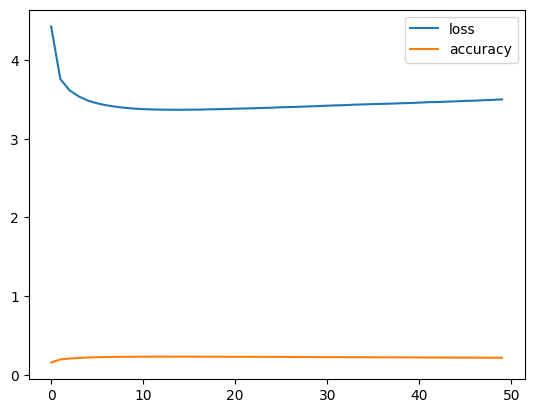

In [5]:
model = create_model()

# fit and train model
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_split=0.1,
    verbose=2,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'accuracy']].plot() # plot loss and accuracy

model.save('../models/ai.keras') # save model

# 3 Prepare Model
## 3.1 Export Dictionary

In [6]:
# taken from https://github.com/Skripkon/chess-engine
int_to_move = dict(zip(move_to_int.values(), move_to_int.keys()))

with open('dict.json', 'w') as f:
    json.dump(int_to_move, f)